# Content<a name='Content'></a>
* [Introduction](#Introduction)
* [Objective](#Objective)
* [Load Data](#Load_Data)
* [Initial Analysis](#IA)
* [Data Cleaning](#Cleaning)
* [Model Preperation](#Model)
* [Reference](#Reference)

# Introduction<a name='Introduction'></a> <sup>[[1]](#ref1)<sup>
[Top](#Content)
    
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. 

**Data Overview <sup>[[2]](#ref2)<sup>**

Out of 2224 boarded passengers, details of 1309 passengers has been provided along with survival status. 

*The data has been split into two groups:*
* training set (train.csv)
* test set (test.csv)

*Column details:*

|Column Name|Definition|Comments|
| ------ | -------- | ------ |
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex|male, female|
|Age|Age in years|Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5|
|sibsp|# of siblings / spouses aboard the Titanic|The dataset defines family relations in this way... * Sibling = brother, sister, stepbrother, stepsister * Spouse = husband, wife (mistresses and fiancés were ignored)|
|parch|# of parents / children aboard the Titanic|The dataset defines family relations in this way... * Parent = mother, father * Child = daughter, son, stepdaughter, stepson * Some children travelled only with a nanny, therefore parch=0 for them.|
|ticket|Ticket number| |
|fare|Passenger fare| |
|cabin|Cabin number| |
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

# Objective<a name='Objective'></a> <sup>[[1]](#ref1)<sup>
[Top](#Content)
    
While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Load Data<a name='Load_Data'></a>
[Top](#Content)

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Check available files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Load train and test data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
total = pd.concat([train,test])

# Initial Analysis<a name='IA'></a>
[Top](#Content)

In [4]:
# Preview of Data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Initial Analysis of data provided
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


**Numerical and Categorical features**
* Numerical features : Features with dtype as int64, float64 (numbers)
* Categorical features : Features with non numeric dtypes

In [6]:
# Classify Numerical features and Categorical features
numerical_features = train.select_dtypes(include=np.number).columns.tolist()
categorical_features = train.select_dtypes(exclude=np.number).columns.tolist()
print('Numerical Features : ')
print(numerical_features)
print('-----------------------')
print('Categorical Features : ')
print(categorical_features)
print('-----------------------')

Numerical Features : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
-----------------------
Categorical Features : 
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
-----------------------


[Reference for select_dtypes](#ref4)

**Null Values analysis**
* We will perform Null Value analysis in data provided (test + train).

Null Value count
-----------------------
Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64
-----------------------


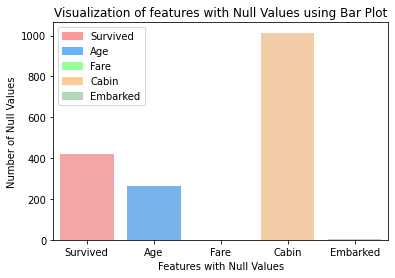

-----------------------


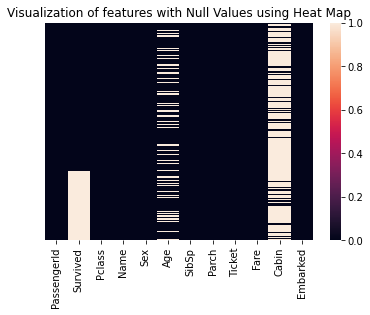

In [7]:
# Null Value count
print('Null Value count')
print('-----------------------')
print(total.isnull().sum()[total.isnull().sum()>0])
print('-----------------------')

# Barplot representation of Null Values
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#B1D8B7']
labels = total.isnull().sum()[total.isnull().sum()>0].index
ax = sns.barplot(x=labels, y=total.isnull().sum()[total.isnull().sum()>0], palette=colors)
h = [mpatches.Patch(color=clr, label=lbl) for clr, lbl in zip(colors, labels)]
ax.legend(h, labels)
plt.title('Visualization of features with Null Values using Bar Plot')
plt.xlabel('Features with Null Values')
plt.ylabel('Number of Null Values')
plt.show()
print('-----------------------')

# Heatmap representation of Null Values
plt.close()
sns.heatmap(total.isna(),yticklabels=False)
plt.title('Visualization of features with Null Values using Heat Map')
plt.show()

[Reference for Seaborn Barplot Legend](#ref3)

* *Survived* : We will ignore Survived as test data is not supposed to have Survival status of passengers.
* *Cabin* : We will not use Cabin in our analysis as out of 1309 passenger details provided 1014 entried have missing value in Cabin feature. (~77% null values)
* *Age* : We will populate the missing value with appropriate values.
* *Fare* : We will populate the missing value with appropriate values.
* *Embarked* : We will populate the missing value with appropriate values.

**Duplicate Value analysis**

We will check if any passenger details are repeated.

We will use below subsets:
* PassengerId
* Name, Sex, Age
* Ticket

In [8]:
# For PassengerId
print('Subset - Passenger Id: ' + str(total.duplicated(subset=['PassengerId'], keep=False).sum()))

# For Name, Sex, Age
print('Subset - Name, Sex, Age: ' + str(total.duplicated(subset=['Name', 'Sex', 'Age'], keep=False).sum()))

# For PassengerId
print('Subset - Ticket: ' + str(total.duplicated(subset=['Ticket'], keep=False).sum()))

Subset - Passenger Id: 0
Subset - Name, Sex, Age: 0
Subset - Ticket: 596


In [9]:
# Further investigation on duplicate Ticket values
total[total.duplicated(subset=['Ticket'])].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24,25,0.0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S
71,72,0.0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.900,NaN,S
88,89,1.0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.000,C23 C25 C27,S
117,118,0.0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.000,NaN,S
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S


In [10]:
# Let us take few examples
total[total['Ticket']=='349909']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,NaN,S
24,25,0.0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S
374,375,0.0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
567,568,0.0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S
389,1281,NaN,3,"Palsson, Master. Paul Folke",male,6.0,3,1,349909,21.075,NaN,S


In [11]:
total[total['Ticket']=='CA 2144']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,60,0.0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
71,72,0.0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S
386,387,0.0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
480,481,0.0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
678,679,0.0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S
683,684,0.0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S
139,1031,NaN,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.9,NaN,S
140,1032,NaN,3,"Goodwin, Miss. Jessie Allis",female,10.0,5,2,CA 2144,46.9,NaN,S


* We can observe that Ticket has Duplicate values.
* On further investigation on Duplicate Tickets using SibSp, Parch and Name; we can conclude that the passengers with same Ticket are travelling togerther.
* Data provided for passengers is Unique and no duplicates are found.

# Data Cleaning <a name='Cleaning'></a>
[Top](#Content)
* Age feature has null values.
* Fare feature has null values.
* Embarked feature has null values.

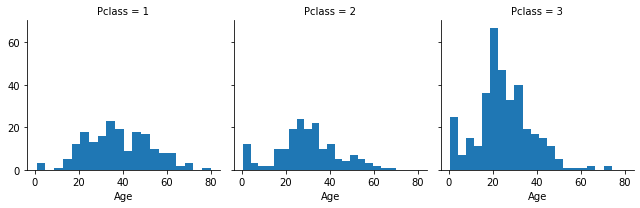

Before: 177
Before: 86
After: 0
After: 0


In [12]:
plt.close()
g = sns.FacetGrid(train, col='Pclass')
g.map(plt.hist, 'Age', bins=20)
plt.show()

print('Before: ' + str(train['Age'].isnull().sum()))
print('Before: ' + str(test['Age'].isnull().sum()))

mean_age_1 = train[(train['Pclass']==1) & (train['Age'].notnull())]['Age'].mean().round(0)
mean_age_2 = train[(train['Pclass']==2) & (train['Age'].notnull())]['Age'].mean().round(0)
mean_age_3 = train[(train['Pclass']==3) & (train['Age'].notnull())]['Age'].mean().round(0)

def update_age(Pclass,Age):
    upd_age = mean_age_1 if Pclass==1 and math.isnan(Age) else mean_age_2 if Pclass==2 and math.isnan(Age) else mean_age_3 if Pclass==3 and math.isnan(Age) else Age
    return upd_age
    
train['Age'] = list(map(update_age, train['Pclass'], train['Age']))
test['Age'] = list(map(update_age, test['Pclass'], test['Age']))

print('After: ' + str(train['Age'].isnull().sum()))
print('After: ' + str(test['Age'].isnull().sum()))

In [13]:
print('Before: ' + str(train['Embarked'].isnull().sum()))
print('Before: ' + str(test['Embarked'].isnull().sum()))

train['Embarked'].fillna(value=train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(value=train['Embarked'].mode()[0], inplace=True)

print('After: ' + str(train['Embarked'].isnull().sum()))
print('After: ' + str(test['Embarked'].isnull().sum()))

Before: 2
Before: 0
After: 0
After: 0


In [14]:
print('Before: ' + str(train['Fare'].isnull().sum()))
print('Before: ' + str(test['Fare'].isnull().sum()))

train['Fare'].fillna(value=train['Fare'].mean(), inplace=True)
test['Fare'].fillna(value=train['Fare'].mean(), inplace=True)

print('After: ' + str(train['Fare'].isnull().sum()))
print('After: ' + str(test['Fare'].isnull().sum()))

Before: 0
Before: 1
After: 0
After: 0


**Convert Data**

In [15]:
train = train.drop(['PassengerId','Cabin','Name','Ticket','Embarked'], axis=1)
test = test.drop(['Cabin','Name','Ticket','Embarked'], axis=1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [16]:
def update_sex(Sex):
    upd_sex = 0 if Sex=='male' else 1
    return upd_sex
    
train['Sex'] = list(map(update_sex, train['Sex']))
test['Sex'] = list(map(update_sex, test['Sex']))

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


In [17]:
def update_family(SibSp, Parch):
    family = SibSp + Parch
    return family
    
train['Family'] = list(map(update_family, train['SibSp'], train['Parch']))
train = train.drop(['SibSp', 'Parch'], axis=1)
test['Family'] = list(map(update_family, test['SibSp'], test['Parch']))
test = test.drop(['SibSp', 'Parch'], axis=1)

train['Family'] = (train['Family']-train['Family'].mean())/train['Family'].std()
test['Family'] = (test['Family']-test['Family'].mean())/test['Family'].std()

train.head()

,Survived,Pclass,Sex,Age,Fare,Family
0,0,3,0,22.0,7.2500,0.059127
1,1,1,1,38.0,71.2833,0.059127
2,1,3,1,26.0,7.9250,-0.560660
3,1,1,1,35.0,53.1000,0.059127
4,0,3,0,35.0,8.0500,-0.560660


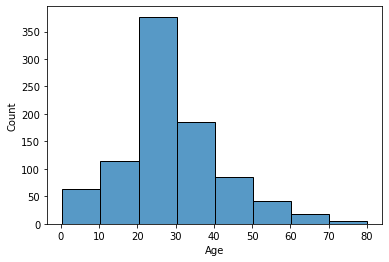

,Survived,Pclass,Sex,Age,Fare,Family
0,0,3,0,-0.549876,7.2500,0.059127
1,1,1,1,0.661127,71.2833,0.059127
2,1,3,1,-0.247125,7.9250,-0.560660
3,1,1,1,0.434064,53.1000,0.059127
4,0,3,0,0.434064,8.0500,-0.560660


In [18]:
plt.close()
sns.histplot(x=train['Age'],bins=8)
plt.show()

train['Age'] = (train['Age']-train['Age'].mean())/train['Age'].std()
test['Age'] = (test['Age']-test['Age'].mean())/test['Age'].std()

train.head()

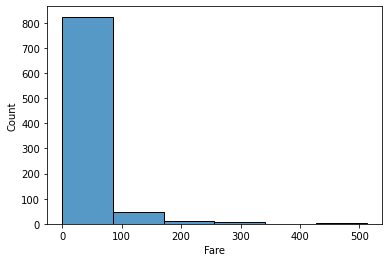

,Survived,Pclass,Sex,Age,Fare,Family
0,0,3,0,-0.549876,-0.502163,0.059127
1,1,1,1,0.661127,0.786404,0.059127
2,1,3,1,-0.247125,-0.488580,-0.560660
3,1,1,1,0.434064,0.420494,0.059127
4,0,3,0,0.434064,-0.486064,-0.560660


In [19]:
plt.close()
sns.histplot(x=train['Fare'],bins=6)
plt.show()
    
train['Fare'] = (train['Fare']-train['Fare'].mean())/train['Fare'].std()
test['Fare'] = (test['Fare']-test['Fare'].mean())/test['Fare'].std()

train.head()

# Model Preperation <a name='Model'></a>
[Top](#Content)

In [20]:
Train_x = train.drop('Survived', axis=1)
Train_y = train['Survived']
Test_x  = test.drop('PassengerId', axis=1).copy()
Train_x.shape, Train_y.shape, Test_x.shape

((891, 5), (891,), (418, 5))

In [21]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(Train_x.values, Train_y.values)
Pred_y = logreg.predict(Test_x.values)
acc_log = round(logreg.score(Train_x.values, Train_y.values) * 100, 2)
acc_log

80.47

In [22]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(Train_x.values, Train_y.values)
Pred_y = sgd.predict(Test_x.values)
acc_sgd = round(sgd.score(Train_x.values, Train_y.values) * 100, 2)
acc_sgd

72.84

In [23]:
# Random Forest

random_forest = RandomForestClassifier()
random_forest.fit(Train_x.values, Train_y.values)
Pred_y = random_forest.predict(Test_x.values)
acc_random_forest = round(random_forest.score(Train_x.values, Train_y.values) * 100, 2)
acc_random_forest

98.09

In [24]:
# Gradient Boosting

gadient_boosting = GradientBoostingClassifier()
gadient_boosting.fit(Train_x.values, Train_y.values)
Pred_y = gadient_boosting.predict(Test_x.values)
acc_gadient_boosting = round(gadient_boosting.score(Train_x.values, Train_y.values) * 100, 2)
acc_gadient_boosting

90.12

In [25]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest','Stochastic Gradient Decent','Gradient Boosting'],
    'Score': [acc_log,acc_random_forest,acc_sgd,acc_gadient_boosting]})
models.sort_values(by='Score', ascending=False)


,Model,Score
1,Random Forest,98.09
3,Gradient Boosting,90.12
0,Logistic Regression,80.47
2,Stochastic Gradient Decent,72.84


In [26]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Train_x.values, Train_y.values)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   3.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.3s
[

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [27]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'learning_rate':[0.01,0.1,1,10,100]
}
# Create a based model
gb = GradientBoostingClassifier()
# Instantiate the grid search model
grid_search_gb = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_gb.fit(Train_x.values, Train_y.values)
grid_search_gb.best_params_

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total ti

{'learning_rate': 0.01,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [28]:
random_forest = RandomForestClassifier(bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200)
random_forest.fit(Train_x.values, Train_y.values)
rf_Final_Pred_y = random_forest.predict(Test_x.values)
acc_random_forest = round(random_forest.score(Train_x.values, Train_y.values) * 100, 2)
acc_random_forest

90.01

In [29]:
gradient_boosting = gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100)
gradient_boosting.fit(Train_x.values, Train_y.values)
gb_Final_Pred_y = random_forest.predict(Test_x.values)
acc_gradient_boosting = round(gradient_boosting.score(Train_x.values, Train_y.values) * 100, 2)
acc_gradient_boosting

90.46

In [30]:
output_data = { 'PassengerId':test.iloc[:, 0], 'Survived':gb_Final_Pred_y}
output = pd.DataFrame(output_data)
output.to_csv('/kaggle/working/submission.csv', index=False)

# Reference<a name='Reference'></a>
* [1. Titanic - Machine Learning from Disaster (Overview)](https://www.kaggle.com/competitions/titanic/overview)<a name='ref1'></a>
* [2. Titanic - Machine Learning from Disaster (Data)](https://www.kaggle.com/competitions/titanic/data)<a name='ref2'></a>
* [3. Reference for Seaborn Barplot Legend](https://wckdouglas.github.io/2017/12/matplotlib-figure-legends)<a name='ref3'></a>
* [4. Reference for select_dtypes](https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas)<a name='ref4'></a>